In [ ]:
# default_exp utils

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from nbdev.test import test_eq
from nbdev.showdoc import *

# Utils
> Useful functiosn to reshape/arrange/reduce raw data into clean data to add to the record

In [ ]:
#export
import numpy as np
import pandas as pd
import os
import glob
import re
from typing import Dict, Tuple, Sequence, Union, Callable
import scipy.interpolate as interpolate
from scipy.ndimage import convolve1d

from theonerig.core import *

In [ ]:
#export
def extend_sync_timepoints(timepoints:np.ndarray, signals:np.ndarray, 
                           up_bound, low_bound=0) -> Tuple[DataChunk, DataChunk]:
    """From `timepoints` and `signals` list, extend it on the left so it includes `low_bound`, and extend it
    up to `up_bound`.
    The number of frame added to the left can be found in the signal_chunk.idx
    """
    assert len(timepoints) == len(signals)
    timepoints = np.array(timepoints)
    signals = np.array(signals)
    spb = np.mean(timepoints[1:]-timepoints[:-1]) #spf: sample_per_bin
        
    #Left and right side are just prolongation of the sample_times up 
    # from (0-sample_per_fr) to (len+sample_per_fr) so it covers all timepoints
    left_side  = np.arange(timepoints[0]-spb , low_bound - spb, -spb)[::-1].astype(int)
    right_side = np.arange(timepoints[-1]+spb,  up_bound + spb,  spb).astype(int)

    new_timepoints = np.concatenate((left_side, 
                                     timepoints, 
                                     right_side))
    
    timepoint_chunk = DataChunk(data=new_timepoints, idx=0, group="sync")
    signal_chunk    = DataChunk(data=signals, idx=len(left_side), group="sync")
    return (timepoint_chunk, signal_chunk)

It extends the timepoints by finding the typical distance between timepoints so it includes both left and right limits.

In [ ]:
extended_tp, extended_sig = extend_sync_timepoints([7900,8900,9900], signals=[1,2,3], up_bound=15000)

In [ ]:
print(extended_tp, end="\n\n")
print(extended_sig, end="\n\n")
print("N timepoints added to the left:",extended_sig.idx)

Group: sync
Starting index: 0
Filling value: 0
[ -100   900  1900  2900  3900  4900  5900  6900  7900  8900  9900 10900
 11900 12900 13900 14900 15900]

Group: sync
Starting index: 8
Filling value: 0
[1 2 3]

N timepoints added to the left: 8


In [ ]:
#export
def align_sync_timepoints(timepoints:DataChunk, signals:DataChunk,
                          ref_timepoints:DataChunk, ref_signals:DataChunk) -> Tuple[DataChunk, DataChunk, DataChunk]:
    """Align the `signals` of a `timepoints` timeserie to a reference `ref_timepoints` with the corresponding
    `ref_signals`. `ref_timepoints` and `ref_signals` are potentially extended and returned
    Returns a DataChunk of the aligned timepoints"""    
    shift_left = ((np.where(ref_signals)[0][0] + ref_signals.idx) 
                  - (np.where(signals)[0][0]) + signals.idx)
    shift_right   = len(ref_timepoints) - (len(timepoints) + shift_left) 

    spb     = np.mean(timepoints[1:]-timepoints[:-1]) #spf: sample_per_bin
    spb_ref = np.mean(ref_timepoints[1:]-ref_timepoints[:-1]) #spf: sample_per_bin
    
    left_timepoints      = np.zeros(0)
    left_timepoints_ref  = np.zeros(0)
    right_timepoints     = np.zeros(0)
    right_timepoints_ref = np.zeros(0)
    
    if shift_left > 0: #the ref started before, need to extend the other
        init  = timepoints[0]-spb
        left_timepoints = np.arange(init , 
                                    init-(spb*shift_left+1), 
                                    -spb)[:shift_left][::-1].astype(int)
    else:
        shift_left = abs(shift_left)
        init  = ref_timepoints[0]-spb_ref
        left_timepoints_ref = np.arange(init , 
                                        init-(spb_ref*shift_left+1), 
                                        -spb_ref)[:shift_left][::-1].astype(int)
        #We also need to shift the index of the ref signals since we increased the size of the ref_timepoints
        ref_signals.idx = ref_signals.idx + len(left_timepoints_ref)
        
    if shift_right > 0: #the ref ended after, need to extend the other
        init  = timepoints[-1]-spb
        right_timepoints = np.arange(init , 
                                    init-(spb*shift_right+1), 
                                    -spb)[:shift_right][::-1].astype(int)
    else:
        shift_right = abs(shift_right)
        init  = ref_timepoints[-1]-spb
        right_timepoints_ref = np.arange(init , 
                                    init-(spb_ref*shift_right+1), 
                                    -spb_ref)[:shift_right][::-1].astype(int)
        
    timepoint    = DataChunk(data=np.concatenate((left_timepoints, 
                                     timepoints, 
                                     right_timepoints)), idx=0, group="sync")
    
    timepoint_ref = DataChunk(data=np.concatenate((left_timepoints_ref, 
                                     ref_timepoints, 
                                     right_timepoints_ref)), idx=0, group="sync")
    
    return (timepoint, timepoint_ref, ref_signals)

In [ ]:
#Aligning these signals 1,2,3 to the previously extended timepoints and signals
extended_tp_2, extended_sig_2 = extend_sync_timepoints([1000,2000,3000], signals=[1,2,3], up_bound=15000)
aligned_timepoints, extended_tp, extended_sig = align_sync_timepoints(timepoints=extended_tp_2, signals=extended_sig_2,
                     ref_timepoints=extended_tp, ref_signals=extended_sig)

#We can observe 8 timepoints added to our function to match all existing frame of the reference.
print(aligned_timepoints)
test_eq(len(aligned_timepoints), len(extended_tp))

Group: sync
Starting index: 0
Filling value: 0
[-9000. -8000. -7000. -6000. -5000. -4000. -3000. -2000. -1000.     0.
  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000.]


In [ ]:
#export
def resample_to_timepoints(timepoints:np.ndarray, data:np.ndarray, 
                             ref_timepoints:DataChunk, group="data") -> DataChunk:
    """Resample the `data` at the `timepoints` to an array at the timepoints of `ref_timepoints`.
    Return a DataChunck of the resampled data belonging to `group`."""
    
    assert len(timepoints) == len(data)
    timepoints = np.array(timepoints)
    data = np.array(data)
    
    start_idx = np.argmax(ref_timepoints >= timepoints[0])
    stop_idx  = np.argmax(ref_timepoints >= timepoints[-1])
    
    if len(ref_timepoints[start_idx:stop_idx]) < len(timepoints): #Downsampling
        distance = (np.argmax(timepoints>ref_timepoints[start_idx+1]) 
                - np.argmax(timepoints>ref_timepoints[start_idx]))
    
        kernel = np.ones(distance)/distance
        data = convolve1d(data, kernel, axis=0) #Smooting to avoid weird sampling

    new_data = interpolate.interp1d(timepoints, data, axis=0)(ref_timepoints[start_idx:stop_idx])

    idx = ref_timepoints.idx + start_idx
    return DataChunk(data=new_data, idx = idx, group=group)

Orig len: 40 Target len: 9


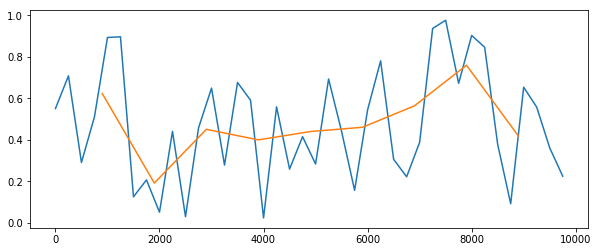

In [ ]:
import matplotlib.pyplot as plt
#Downsampling
np.random.seed(3)
len_data = 40
wrong_dim_data = np.random.rand(len_data)
wrong_dim_timepoints = np.linspace(0,10000,len_data,endpoint=False, dtype=int)

downsamp_data = resample_to_timepoints(wrong_dim_timepoints, wrong_dim_data, 
                                         ref_timepoints=extended_tp)

plt.figure(figsize=(10,4))
plt.plot(wrong_dim_timepoints, wrong_dim_data)
start,stop = downsamp_data.idx, downsamp_data.idx+len(downsamp_data)
plt.plot(extended_tp[start:stop], downsamp_data)
print("Orig len:", len(wrong_dim_data), "Target len:",len(extended_tp[start:stop]))

Orig len: 5 Target len: 8


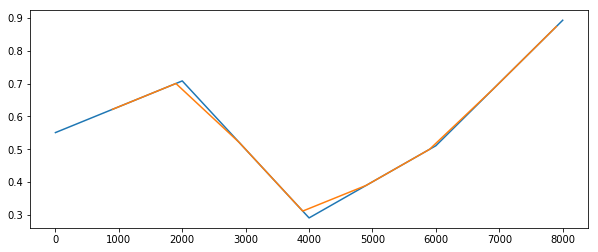

In [ ]:
#Upsampling
np.random.seed(3)
len_data = 5
wrong_dim_data = np.random.rand(len_data)
wrong_dim_timepoints = np.linspace(0,10000,len_data,endpoint=False, dtype=int)

downsamp_data = resample_to_timepoints(wrong_dim_timepoints, wrong_dim_data, 
                                         ref_timepoints=extended_tp)

plt.figure(figsize=(10,4))
plt.plot(wrong_dim_timepoints, wrong_dim_data)
start,stop = downsamp_data.idx, downsamp_data.idx+len(downsamp_data)
plt.plot(extended_tp[start:stop], downsamp_data)
print("Orig len:", len(wrong_dim_data), "Target len:",len(extended_tp[start:stop]))

In [ ]:
#export
def stim_to_dataChunk(stim_values, stim_start_idx, reference:DataChunk) -> DataChunk:
    """Factory function for DataChunk of a stimulus"""
    return DataChunk(data=np.squeeze(stim_values), idx = (stim_start_idx + reference.idx), group="stim")

In [ ]:
#export
def spike_to_dataChunk(spike_timepoints, ref_timepoints:DataChunk) -> DataChunk:
    """`spike_timepoints` must be a dictionnary of cell spike_timepoints list. This function then
    bins the """
    type_cast = type(list(spike_timepoints.keys())[0])
    cell_keys = sorted(map(int, 
                                    spike_timepoints.keys()))
    cell_map = dict([ (cell_key, i) for i, cell_key in enumerate(cell_keys) ])
    spike_bins = np.zeros((ref_timepoints.shape[0], len(cell_keys)))
    bins = np.concatenate((ref_timepoints[:], [(ref_timepoints[-1]*2)-ref_timepoints[-2]]))

    for i, cell in enumerate(cell_keys):
        spike_bins[:, i] = np.histogram(spike_timepoints[type_cast(cell)], bins)[0]
        
    datachunk = DataChunk(data=spike_bins, idx = ref_timepoints.idx, group="cell")
    datachunk.attrs["cell_map"] = cell_map
    return datachunk

In [ ]:
#export
def parse_stim_args(stim_name, stim_ref):
    """Function really specific to Asari Lab stimuli. Stimuli were stored as h5 files. This function parse
    the attributes of the stimuli that were stored in the h5 references of the stimuli."""
    args = {}
    if stim_name in ["chirp_am", "chirp_fm", "chirp_co"]:
        #+ add on off timings at the beginning?
        args["n_repeat"] = int(stim_ref.attrs["n_repeat"])
    if stim_name in ["chirp_fm"]:
        args["max_freq"] = int(stim_ref.attrs["max_frequency"])
    if stim_name in ["moving_gratings"]:
        #+ Convert to degree units
        args["n_fr_stim"] = int(stim_ref.attrs["n_frame_on"])#.keys()
        args["n_fr_interstim"] = int(stim_ref.attrs["n_frame_off"])
        args["n_repeat"] = int(stim_ref.attrs["n_repeat"])
        args["n_angle"] = int(stim_ref.attrs["n_angle"])
        args["sp_freqs"] = list(map(int,stim_ref.attrs["spatial_frequencies"][1:-1].split(",")))
        args["speeds"] = list(map(int,stim_ref.attrs["speeds"][1:-1].split(",")))
    if stim_name in ["flickering_bars", "checkerboard", "flickering_bars_pr"]:
        #Get the size of the sides in angle
        pass
    return args

In [ ]:
#export
def peak_sta_frame(sta):
    abs_sta   = np.abs(sta)
    idx_frame = np.unravel_index(abs_sta.argmax(), sta.shape)[0]
    return sta[idx_frame]

def stim_inten_norm(stim_inten):
    stim_inten = stim_inten.astype(float)
    stim_inten -= np.min(stim_inten)
    stim_inten -= np.max(stim_inten)/2
    stim_inten /= np.max(np.abs(stim_inten))
    return np.round(stim_inten, 2)
#     stim_inten[stim_inten==255] = 1
#     stim_inten[stim_inten==0]   = -1
#     stim_inten[(stim_inten==127) | (stim_inten==128)] = 0 #In case

In [ ]:
#export
def twoP_dataChunks(ref_timepoints:DataChunk, frame_timepoints, len_epochs, C_matrix, S_matrix):
    C_datachunk_l = []
    S_datachunk_l = []
    cursor = 0
    for i, len_epoch in enumerate(len_epochs):
        start_idx = np.argmax(ref_timepoints>frame_timepoints[i][0])
        stop_idx  = np.argmax(ref_timepoints>frame_timepoints[i][-6]) #-6 to exclujde the always present extra 5 frame of the calcium pulses
        sub_C, sub_S = C_matrix.T[cursor:cursor+len_epoch], S_matrix.T[cursor:cursor+len_epoch]
        cursor += len_epoch
        f = interpolate.interp1d(range(len_epoch), sub_C, axis=0)
        C_datachunk_l.append(DataChunk(data=f(np.linspace(0,len_epoch-1,stop_idx-start_idx)), 
                                       idx=start_idx, 
                                       group="cell"))
        f = interpolate.interp1d(range(len_epoch), sub_S, axis=0)
        S_datachunk_l.append(DataChunk(data=f(np.linspace(0,len_epoch-1,stop_idx-start_idx)), 
                                       idx=start_idx, 
                                       group="cell"))
    return (C_datachunk_l, S_datachunk_l)

In [ ]:
#export
def img_2d_fit(shape, param_d, f):
    y_, x_ = shape
    xy = np.meshgrid(range(x_), range(y_))
    return f(xy, **param_d).reshape(y_,x_)

In [ ]:
#export
def fill_nan(A):
    '''
    interpolate to fill nan values. BRYAN WOODS@StackOverflow
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [ ]:
#export
def group_direction_response(stim_prop, spike_counts, n_repeat, n_cond=32):
    """Group the record according to conditions."""
    
    n_cell = spike_counts.shape[-1]
    condition_repeat = stim_prop.reshape(n_repeat*n_cond,-1,3)[:,1,:]
    spike_resh       = spike_counts.reshape(n_repeat*n_cond,-1,n_cell)
    angles = np.unique(condition_repeat[:,1])

    data_dict = {}
    for cond in np.unique(condition_repeat, axis=0):
        spat_freq, angle, speed = tuple(cond)
        idx_cond = np.argwhere(np.all(condition_repeat==cond, axis=1))[:,0]

        cond_key = str(spat_freq)+"@"+str(round(speed,2))
        if cond_key not in data_dict.keys():
            data_dict[cond_key] = np.empty((8, len(idx_cond), *spike_resh[0].shape))

        idx_angle = np.where(angle==angles)[0][0]
        data_dict[cond_key][idx_angle] = np.array([spike_resh[idx] for idx in idx_cond])
    return data_dict

In [ ]:
#export
def group_chirp_bumps(stim_inten, spike_counts, n_repeat):
    repeat = stim_inten.reshape(n_repeat,-1)[0]
    spike_counts = spike_counts.reshape(n_repeat,-1,spike_counts.shape[-1])
    epoch_l = [0]
    end_l = [len(repeat)]
    i = 1
    curr = repeat[0]

    while True:
        while repeat[i]==curr:
            i+=1
        epoch_l.append(i)
        curr = repeat[i]
        if curr==repeat[i+1]:
            continue
        else:
            break

    i = len(repeat)-2
    curr = repeat[-1]

    while True:
        while repeat[i]==curr:
            i-=1
        end_l.insert(0,i)
        curr = repeat[i]
        if curr==repeat[i-1]:
            continue
        else:
            break
    slices = [slice(epoch_l[i-1],epoch_l[i]) for i in range(1,len(epoch_l))]
    slices.extend([slice(end_l[i-1],end_l[i]) for i in range(1,len(end_l))])

    res_d = {}
    for slc in slices:
        key = str(stim_inten[slc.start])+"@"+str(slc.start)
        res_d[key] = spike_counts[:,slc]

    return res_d

In [ ]:
#export
def limited_stim_ensemble(stim_inten, cell_sta, Hw=16, window=4):
    y,x = np.argwhere(np.abs(cell_sta)==1)[0][1:]
    x_low, x_high = max(0, x-window), min(cell_sta.shape[2]-1, x+window)
    y_low, y_high = max(0, y-window), min(cell_sta.shape[1]-1, y+window)
    y, x = np.meshgrid(np.linspace(y_low,y_high,window*2+1, dtype=int), 
                       np.linspace(x_low,x_high,window*2+1, dtype=int))
    limited_stim = stim_inten[:,y, x]
    
    stim_ensemble = np.zeros((len(limited_stim)-Hw, limited_stim.shape[-2]*limited_stim.shape[-1]*Hw))
    for i in range(Hw, len(limited_stim)):
        flat_stim = np.ndarray.flatten(limited_stim[i-Hw:i]) #,5:11,22:28
        stim_ensemble[i-Hw] = flat_stim
    return stim_ensemble

In [ ]:
#export
def buszaki_shank_channels(channel_positions):
    shank_1_mask = channel_positions[:,0]<180
    shank_1_idx  = np.argwhere(shank_1_mask)[:,0]
    shank_2_mask = (channel_positions[:,0]<380) & np.invert(shank_1_mask)
    shank_2_idx  = np.argwhere(shank_2_mask)[:,0]
    shank_4_mask = channel_positions[:,0]>580
    shank_4_idx  = np.argwhere(shank_4_mask)[:,0]
    shank_3_mask = (channel_positions[:,0]>380) & np.invert(shank_4_mask)
    shank_3_idx  = np.argwhere(shank_3_mask)[:,0]

    shanks_idx = np.zeros((4,8), dtype=int) - 1 #Initialize with -1 in case of channel missing
    shanks_idx[0,:len(shank_1_idx)] = shank_1_idx
    shanks_idx[1,:len(shank_2_idx)] = shank_2_idx
    shanks_idx[2,:len(shank_3_idx)] = shank_3_idx
    shanks_idx[3,:len(shank_4_idx)] = shank_4_idx
    return shanks_idx

In [ ]:
#export
def phy_results_dict(phy_dir):
    res_dict = {}
    res_dict["amplitudes"] = np.load(phy_dir+"/amplitudes.npy")
    res_dict["channel_map"] = np.load(phy_dir+"/channel_map.npy")
    res_dict["channel_positions"] = np.load(phy_dir+"/channel_positions.npy")
    res_dict["spike_clusters"] = np.load(phy_dir+"/spike_clusters.npy")
    res_dict["spike_templates"] = np.load(phy_dir+"/spike_templates.npy")
    res_dict["spike_times"] = np.load(phy_dir+"/spike_times.npy")
    res_dict["templates"] = np.load(phy_dir+"/templates.npy")
    return res_dict

In [ ]:
#export
def format_pval(pval, significant_figures=2):
    return '{:g}'.format(float('{:.{p}g}'.format(pval, p=significant_figures)))

In [ ]:
#export
def get_calcium_stack_lenghts(folder):
    record_lenghts = []
    pattern_nFrame = r".*number=(\d*) .*"
    for fn in glob.glob(folder+"/*.txt"):
        with open(fn) as f:
            line = f.readline()
            record_lenghts.append(int(re.findall(pattern_nFrame, line)[0]))
    return record_lenghts

In [ ]:
#export
def stim_recap_df(reM):
    def parse_stim(stim_dc):
        param_d = {}
        param_d["hash"]        = stim_dc.attrs["md5"][:10] #the first 10 letters are more than enough
        param_d["n frames"]    = len(stim_dc)
        param_d["stimulus"]    = stim_dc.attrs["name"]

        if stim_dc.attrs["name"] in ["checkerboard", "fullfield_flicker", "flickering_bars", "flickering_bars_pr"]:
            param_d["frequency"] = stim_dc.attrs["refresh_rate"]
        elif stim_dc.attrs["name"] in ["chirp_am","chirp_fm","chirp_freq_epoch", "chirp_co"]:
            param_d["n ON"]      = int(stim_dc.attrs["tSteadyON_s"]*60)
            param_d["n OFF"]     = int(stim_dc.attrs["tSteadyOFF_s"]*60)
            param_d["n repeats"] = int(stim_dc.attrs["n_repeat"])
            if stim_dc.attrs["name"] in ["chirp_am","chirp_co"]:
                param_d["frequency"] = stim_dc.attrs["contrast_frequency"]
            elif stim_dc.attrs["name"]=="chirp_fm":
                param_d["frequency"] = stim_dc.attrs["max_frequency"]
            elif stim_dc.attrs["name"]=="chirp_freq_epoch":
                param_d["frequency"] = str([round(60/nfr,2) for nfr in dc.attrs["n_frame_cycle"]])
        elif stim_dc.attrs["name"] in ["fullfield_color_mix"]:
            param_d["n ON"]      = int(stim_dc.attrs["n_frame_on"])
            param_d["n OFF"]     = int(stim_dc.attrs["n_frame_off"])
            param_d["n repeats"] = int(stim_dc.attrs["n_repeat"])
        elif stim_dc.attrs["name"]=="moving_gratings":
            param_d["n repeats"]           = stim_dc.attrs["n_repeat"]
            param_d["n ON"]                = stim_dc.attrs["n_frame_on"]
            param_d["n OFF"]               = stim_dc.attrs["n_frame_off"]
            param_d["speeds"]              = stim_dc.attrs["speeds"]
            param_d["spatial frequencies"] = stim_dc.attrs["spatial_frequencies"]
            
        if "frame_replacement" in stim_dc.attrs:
            param_d["total drop"] = len(stim_dc.attrs["frame_replacement"])
        if "signal_shifts" in stim_dc.attrs:
            shift = 0
            for _, which_shift in stim_dc.attrs["signal_shifts"]:
                if which_shift=="ins":
                    shift += 1
                elif which_shift=="del":
                    shift -= 1
            param_d["total shift"] = shift

        return param_d

    df = pd.DataFrame(columns=["stimulus", "hash", "n frames", "n repeats",
                               "frequency", "n ON", "n OFF", "speeds", "spatial frequencies",
                              "total shift", "total drop"])
    cursor = 0
    for k, dc_l in reM[0]:
        dc = dc_l[0]
        if dc.group == "stim":
            serie = pd.Series(data=parse_stim(dc), name=cursor)
            df = df.append(serie, ignore_index=False)
            cursor+=1

    df = df.fillna("")
    return df

def stim_recap_df_old(h5_stim_group):
    df = pd.DataFrame(index=["checkerboard", "fullfield_flicker", "flickering_bars", 
                             "chirp_am", "chirp_fm", "moving_gratings"], 
                     columns=["stimulus", "hash", "n frames", "n repeats", 
                              "frequency", "n ON", "n OFF", "speeds", "spatial frequencies"])
    df.loc["checkerboard"]["stimulus"]     = "checkerboard"
    df.loc["fullfield_flicker"]["stimulus"]= "fullfield_flicker"
    df.loc["flickering_bars"]["stimulus"]  = "flickering_bars"
    df.loc["chirp_am"]["stimulus"]         = "chirp_am"
    df.loc["chirp_fm"]["stimulus"]         = "chirp_fm"
    df.loc["moving_gratings"]["stimulus"]  = "moving_gratings"
    for stim_key in h5_stim_group.keys():
        extract_old_stimulus_metadata(h5_stim_group[stim_key], df)
        
    df = df.fillna('')
    return df

    def extract_old_stimulus_metadata(h5_group, df):
        stim_name = h5_group.attrs["name"]
        nhash_letters = 10
        if stim_name=="checkerboard":
            df.loc["checkerboard"]["hash"]      = h5_group.attrs["hash"][:nhash_letters]
            df.loc["checkerboard"]["n frames"]    = len(h5_group["intensity"])
            df.loc["checkerboard"]["frequency"]      = h5_group.attrs["refresh_rate"]
            df.loc["checkerboard"]["stimulus"]  = stim_name

        elif stim_name=="fullfield_flicker":    
            df.loc["fullfield_flicker"]["hash"]   = h5_group.attrs["hash"][:nhash_letters]
            df.loc["fullfield_flicker"]["n frames"] =len(h5_group["intensity"])
            df.loc["fullfield_flicker"]["frequency"]   = h5_group.attrs["refresh_rate"]
            df.loc["fullfield_flicker"]["stimulus"]  = stim_name

        elif stim_name=="flickering_bars" or stim_name=="flickering_bars_pr":    
            df.loc["flickering_bars"]["hash"]   = h5_group.attrs["hash"][:nhash_letters]
            df.loc["flickering_bars"]["n frames"] = len(h5_group["intensity"])
            df.loc["flickering_bars"]["frequency"]   = h5_group.attrs["refresh_rate"]
            df.loc["flickering_bars"]["stimulus"]  = stim_name

        elif stim_name=="chirp_am":    
            df.loc["chirp_am"]["hash"]    = h5_group.attrs["hash"][:nhash_letters]
            df.loc["chirp_am"]["n frames"]  = len(h5_group["intensity"])
            df.loc["chirp_am"]["n repeats"] = h5_group.attrs["n_repeat"]
            df.loc["chirp_am"]["frequency"]    = h5_group.attrs["contrast_frequency"]
            df.loc["chirp_am"]["n ON"]     = int(float(h5_group.attrs["tSteadyON_s"])*60)
            df.loc["chirp_am"]["n OFF"]    = int(float(h5_group.attrs["tSteadyOFF_s"])*60)
            df.loc["chirp_am"]["stimulus"]  = stim_name

        elif stim_name=="chirp_freq_epoch":
            df.loc["chirp_fm"]["hash"]    = h5_group.attrs["hash"][:nhash_letters]
            df.loc["chirp_fm"]["n frames"]  = len(h5_group["intensity"])
            df.loc["chirp_fm"]["n repeats"] = h5_group.attrs["n_repeat"]
            df.loc["chirp_fm"]["n ON"]     = int(float(h5_group.attrs["tSteadyON_s"])*60)
            df.loc["chirp_fm"]["n OFF"]    = int(float(h5_group.attrs["tSteadyOFF_s"])*60)
            df.loc["chirp_fm"]["stimulus"]  = stim_name

        elif stim_name=="moving_gratings":
            df.loc["moving_gratings"]["hash"]                = h5_group.attrs["hash"][:nhash_letters]
            df.loc["moving_gratings"]["n frames"]              = len(h5_group["intensity"])
            df.loc["moving_gratings"]["n repeats"]             = h5_group.attrs["n_repeat"]
            df.loc["moving_gratings"]["n ON"]                 = h5_group.attrs["n_frame_on"]
            df.loc["moving_gratings"]["n OFF"]                = h5_group.attrs["n_frame_off"]
            df.loc["moving_gratings"]["speeds"]              = h5_group.attrs["speeds"]
            df.loc["moving_gratings"]["spatial frequencies"] = h5_group.attrs["spatial_frequencies"]
            df.loc["moving_gratings"]["stimulus"]  = stim_name


In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted 05_database.ipynb.
Converted 10_synchro.io.ipynb.
Converted 11_synchro.extracting.ipynb.
Converted 12_synchro.processing.ipynb.
Converted 99_testdata.ipynb.
Converted index.ipynb.
